In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0')

# Load Data

In [30]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows.npy'

stride = 1
L_train_raw = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev_raw = sp.sparse.load_npz(L_dev_path).todense()
Y_dev_raw = np.load(Y_dev_path)
L_test_raw = sp.sparse.load_npz(L_test_path).todense()
Y_test_raw = np.load(Y_test_path)

T = 5

L_train = torch.FloatTensor(L_train_raw[:L_train_raw.shape[0] - (L_train_raw.shape[0] % T)]).to(device)
L_dev = torch.FloatTensor(L_dev_raw[:L_dev_raw.shape[0] - (L_dev_raw.shape[0] % T)]).to(device)
Y_dev = torch.FloatTensor(Y_dev_raw[:Y_dev_raw.shape[0] - (Y_dev_raw.shape[0] % T)]).to(device)
L_test = torch.FloatTensor(L_test_raw[:L_test_raw.shape[0] - (L_test_raw.shape[0] % T)]).to(device)
Y_test = torch.FloatTensor(Y_test_raw[:Y_test_raw.shape[0] - (Y_test_raw.shape[0] % T)]).to(device)
m_per_task = L_train.size(1)
n_frames_train = L_train.size(0)
n_patients_train = n_frames_train//T
n_frames_dev = L_dev.size(0)
n_patients_dev = n_frames_dev//T
n_frames_test = L_test.size(0)
n_patients_test = n_frames_test//T

# MRI_data_naive = {'Li_train': (L_train.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'Li_dev': (L_dev.unsqueeze(2) == torch.FloatTensor([-1,1,0]).to(device).unsqueeze(0).unsqueeze(0)).argmax(2),
#                   'R_dev': (Y_dev.unsqueeze(1) == torch.FloatTensor([-1,1]).to(device).unsqueeze(0)).argmax(1),
#                   'm':m_per_task, 'T':1,
#                  }

# don't need to transform the raw data
MRI_data_naive = {'Li_train': L_train.long().to(device),
                  'Li_dev': L_dev.long().to(device),
                  'R_dev': Y_dev.long().to(device),
                  'Li_test': L_test.long().to(device),
                  'R_test': Y_test.long().to(device),
                  'm':m_per_task, 'T':1,
                 }
MRI_data_naive['class_balance'] = normalize((MRI_data_naive['R_dev'].unsqueeze(1)==torch.arange(2, device=device).unsqueeze(0)).sum(0).float(), 
                                            dim=0, p=1)
MRI_data_temporal = {'Li_train': MRI_data_naive['Li_train'].view(n_patients_train, (m_per_task*T)),
                     'Li_dev': MRI_data_naive['Li_dev'].view(n_patients_dev, (m_per_task*T)),
                     'R_dev': MRI_data_naive['R_dev']*(2**T-1),
                     'Li_test': MRI_data_naive['Li_test'].view(n_patients_test, (m_per_task*T)),
                     'R_test': MRI_data_naive['R_test']*(2**T-1),
                     'm': m_per_task * T, 'T': T,
                    } 
MRI_data_temporal['class_balance'] = normalize((MRI_data_temporal['R_dev'].unsqueeze(1)==torch.arange(2**T, device=device).unsqueeze(0)).sum(0).float(), 
                                                dim=0, p=1)

# Naive Model

In [12]:
MRI_data_naive['class_balance']

tensor([0., 1.], device='cuda:0')

In [5]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           # class_balance=MRI_data_naive['class_balance'], 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=3000, lr=4.087885261759692e-05,
         momentum=0.9, clamp=True, seed=2)

iteration=0 loss=50.6702766418457
iteration=300 loss=8.80715274810791
iteration=600 loss=3.66485595703125
iteration=900 loss=1.8281009197235107
iteration=1200 loss=0.9653668999671936
iteration=1500 loss=0.6120548844337463
iteration=1800 loss=0.4767417907714844
iteration=2100 loss=0.40450260043144226
iteration=2400 loss=0.3607012629508972
iteration=2700 loss=0.3310929536819458
iteration=2999 loss=0.30959445238113403


In [6]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.125
F1: 0.389
Recall: 0.712
Precision: 0.268


In [8]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.051
F1: 0.143
Recall: 0.288
Precision: 0.095


In [ ]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.4, .6]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=5000, lr=4.087885261759692e-04,
         momentum=0.9, clamp=False, seed=10)

In [41]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.171
F1: 0.488
Recall: 0.971
Precision: 0.326


In [44]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.069
F1: 0.185
Recall: 0.389
Precision: 0.121


In [64]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.3, .7]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=1000, lr=2.087885261759692e-02,
         momentum=0., clamp=False, seed=11)

iteration=0 loss=53.89699172973633
iteration=100 loss=0.3030668795108795
iteration=200 loss=0.23939409852027893
iteration=300 loss=0.22569435834884644
iteration=400 loss=0.22112223505973816
iteration=500 loss=0.21906107664108276
iteration=600 loss=0.2178979068994522
iteration=700 loss=0.2171371728181839
iteration=800 loss=0.21659354865550995
iteration=900 loss=0.21618370711803436
iteration=999 loss=0.21586711704730988


In [65]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.172
F1: 0.489
Recall: 0.975
Precision: 0.326


In [66]:
# Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Flipping Parameters
Accuracy: 0.137
F1: 0.245
Recall: 0.777
Precision: 0.145


In [81]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([-.1, 1.1]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'], num_iter=5000, lr=1.087885261759692e-02,
         momentum=0.3, clamp=False, seed=11)

iteration=0 loss=66.03443145751953
iteration=500 loss=2.6357004642486572
iteration=1000 loss=0.3299635946750641
iteration=1500 loss=0.29519757628440857
iteration=2000 loss=0.2911560535430908
iteration=2500 loss=0.28930333256721497
iteration=3000 loss=0.2881740927696228
iteration=3500 loss=0.28736594319343567
iteration=4000 loss=0.28671225905418396
iteration=4500 loss=0.2861360013484955
iteration=4999 loss=0.2856000065803528


In [82]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")
    # Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.154
F1: 0.452
Recall: 0.874
Precision: 0.304
Flipping Parameters
Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000


In [98]:
naive_model = DPLabelModel(m=m_per_task, 
                           T=1,
                           edges=[],
                           coverage_sets=[[0,]]*m_per_task,
                           mu_sharing=[[i,] for i in range(m_per_task)],
                           phi_sharing=[],
                           device=device,
                           class_balance=torch.tensor([.4, .6]).to(device), 
                           seed=0)
optimize(naive_model, L_hat=MRI_data_naive['Li_train'][::4000], num_iter=2000, lr=1.087885261759692e-03,
         momentum=.9, clamp=False, seed=11)

iteration=0 loss=52.20237731933594
iteration=200 loss=0.23215782642364502
iteration=400 loss=0.19091296195983887
iteration=600 loss=0.183028444647789
iteration=800 loss=0.18011479079723358
iteration=1000 loss=0.17864780128002167
iteration=1200 loss=0.17776866257190704
iteration=1400 loss=0.17718084156513214
iteration=1600 loss=0.17675688862800598
iteration=1800 loss=0.1764335036277771
iteration=1999 loss=0.176177516579628


In [94]:
R_pred = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")
    # Flipping params
print("Flipping Parameters")
naive_model.flip_params()
R_pred_flipped = naive_model.predict(MRI_data_naive['Li_dev'])
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(MRI_data_naive['R_dev'].cpu(), R_pred_flipped.cpu(), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.171
F1: 0.488
Recall: 0.971
Precision: 0.326
Flipping Parameters
Accuracy: 0.069
F1: 0.185
Recall: 0.389
Precision: 0.121


# Timeseries model

In [6]:
valid_target = Y_dev.long()
T = 5

feasible_y = np.array([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]])

feasible_y[feasible_y==-1] = 0
feasible_y = feasible_y.tolist()
possibilities = list(map(lambda l : ''.join(map(str,l)), feasible_y))

class_balance = np.empty(2 ** T)
#compute class balance from dev set and use laplace smoothing

valid_target_copy = np.copy(valid_target)
valid_target_copy[valid_target_copy == 2] = 0

assert len(valid_target_copy) % T == 0
num_windows = len(valid_target_copy) / T

freq = {}
for i in range(0, len(valid_target_copy), T):
    s = ''.join(map(str,valid_target_copy[i:i+T]))
    if s in freq:
        freq[s] += 1
    else:
        freq[s] = 1

for i in range(len(class_balance)):
    if possibilities[i] in freq and freq[possibilities[i]] > 5:
        class_balance[i] = (freq[possibilities[i]] + 1) / (num_windows + len(possibilities))
    else:
        class_balance[i] = 0.

In [7]:
%%time
best = None
for iterations in [1, 5, 10, 25, 50, 100, 200]:
    for learning_rate in [1e-4, 1e-5, 1e-6, 1e-7]:
        print(iterations, learning_rate)
        max_seed = 10
        temporal_models = [None,]*max_seed
        for seed in range(max_seed):
            print(seed)
            markov_model = DPLabelModel(m=m_per_task*T, 
                                        T=T,
                                        edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                        coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                        mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                        phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i)
                                                      for t in range(T-1)] for i in range(m_per_task)],
                                        device=device,
                                        class_balance=torch.tensor(class_balance).float().to(device),
                                        seed=seed)
            optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=iterations,
                     lr=1e-5, momentum=0.8, clamp=True, 
                     verbose=iterations >= 10, seed=seed)
            temporal_models[seed] = markov_model

        for seed, model in enumerate(temporal_models):
            Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            scores = [iterations, seed, model]
            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
                
            model.flip_params()
            R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

            for metric in ['accuracy', 'f1', 'recall', 'precision']:
                score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
                print(f"{metric.capitalize()}: {score:.3f}")

                scores.append(score)
            
            model.flip_params()

            if best == None or scores[4] > max(best[4], best[8]) or scores[8] > max(best[4], best[8]):
                best = scores
            print()

print(best)

1 0.0001
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.123
F1: 0.742
Recall: 0.701
Precision: 0.789
Accuracy: 0.010
F1: 0.031
Recall: 0.057
Precision: 0.021

Accuracy: 0.052
F1: 0.377
Recall: 0.296
Precision: 0.521
Accuracy: 0.097
F1: 0.363
Recall: 0.550
Precision: 0.271

Accuracy: 0.139
F1: 0.461
Recall: 0.787
Precision: 0.326
Accuracy: 0.015
F1: 0.074
Recall: 0.084
Precision: 0.067

Accuracy: 0.095
F1: 0.630
Recall: 0.538
Precision: 0.760
Accuracy: 0.042
F1: 0.085
Recall: 0.237
Precision: 0.052

Accuracy: 0.046
F1: 0.223
Recall: 0.261
Precision: 0.195
Accuracy: 0.002
F1: 0.021
Recall: 0.011
Precision: 0.250

Accuracy: 0.025
F1: 0.068
Recall: 0.140
Precision: 0.045
Accuracy: 0.072
F1: 0.540
Recall: 0.412
Precision: 0.782

Accuracy: 0.046
F1: 0.166
Recall: 0.261
Precision: 0.121
Accuracy: 0.147
F1: 0.687
Recall: 0.834
Precision: 0.584

Accuracy: 0.051
F1: 0.103
Recall: 0.292
Precision: 0.063
Accuracy: 0.079
F1: 0.595
Recall: 0.447
Precision: 0.892

Accuracy: 0.006
F1: 0.018
Recall: 0.034
Precision: 


5 1e-07
0
1
2
3
4
5
6
7
8
9
Accuracy: 0.138
F1: 0.714
Recall: 0.786
Precision: 0.654
Accuracy: 0.014
F1: 0.044
Recall: 0.081
Precision: 0.030

Accuracy: 0.110
F1: 0.698
Recall: 0.625
Precision: 0.789
Accuracy: 0.083
F1: 0.176
Recall: 0.472
Precision: 0.108

Accuracy: 0.123
F1: 0.413
Recall: 0.700
Precision: 0.292
Accuracy: 0.025
F1: 0.113
Recall: 0.142
Precision: 0.093

Accuracy: 0.113
F1: 0.707
Recall: 0.644
Precision: 0.783
Accuracy: 0.034
F1: 0.069
Recall: 0.192
Precision: 0.042

Accuracy: 0.058
F1: 0.396
Recall: 0.330
Precision: 0.494
Accuracy: 0.002
F1: 0.007
Recall: 0.011
Precision: 0.005

Accuracy: 0.058
F1: 0.288
Recall: 0.330
Precision: 0.256
Accuracy: 0.057
F1: 0.335
Recall: 0.326
Precision: 0.345

Accuracy: 0.014
F1: 0.061
Recall: 0.082
Precision: 0.049
Accuracy: 0.161
F1: 0.379
Recall: 0.914
Precision: 0.239

Accuracy: 0.128
F1: 0.357
Recall: 0.725
Precision: 0.237
Accuracy: 0.014
F1: 0.076
Recall: 0.082
Precision: 0.071

Accuracy: 0.022
F1: 0.072
Recall: 0.125
Precision: 

iteration=8 loss=2982.943359375
iteration=9 loss=2863.72216796875
iteration=9 loss=2863.72216796875
6
iteration=0 loss=9812.7412109375
iteration=1 loss=6476.904296875
iteration=2 loss=4289.482421875
iteration=3 loss=3394.206298828125
iteration=4 loss=3155.933837890625
iteration=5 loss=3239.47509765625
iteration=6 loss=3395.568359375
iteration=7 loss=3388.4248046875
iteration=8 loss=3244.39990234375
iteration=9 loss=3007.44970703125
iteration=9 loss=3007.44970703125
7
iteration=0 loss=12266.5830078125
iteration=1 loss=6776.751953125
iteration=2 loss=4109.3974609375
iteration=3 loss=3279.71923828125
iteration=4 loss=3202.09814453125
iteration=5 loss=3462.451416015625
iteration=6 loss=3759.118896484375
iteration=7 loss=3729.509521484375
iteration=8 loss=3461.197265625
iteration=9 loss=3091.236328125
iteration=9 loss=3091.236328125
8
iteration=0 loss=12965.1884765625
iteration=1 loss=7627.36376953125
iteration=2 loss=4756.70458984375
iteration=3 loss=3683.372802734375
iteration=4 loss=3371

iteration=6 loss=2885.357177734375
iteration=7 loss=2813.029296875
iteration=8 loss=2693.588134765625
iteration=9 loss=2532.54248046875
iteration=9 loss=2532.54248046875
2
iteration=0 loss=7071.05126953125
iteration=1 loss=5959.0322265625
iteration=2 loss=4745.20166015625
iteration=3 loss=3887.12255859375
iteration=4 loss=3390.8017578125
iteration=5 loss=3163.537109375
iteration=6 loss=3107.765869140625
iteration=7 loss=3117.98388671875
iteration=8 loss=3094.12451171875
iteration=9 loss=2981.397705078125
iteration=9 loss=2981.397705078125
3
iteration=0 loss=4940.92236328125
iteration=1 loss=4493.43408203125
iteration=2 loss=3943.192626953125
iteration=3 loss=3505.8544921875
iteration=4 loss=3226.01025390625
iteration=5 loss=3073.938232421875
iteration=6 loss=3000.66064453125
iteration=7 loss=2955.044921875
iteration=8 loss=2894.46435546875
iteration=9 loss=2796.409423828125
iteration=9 loss=2796.409423828125
4
iteration=0 loss=7040.8896484375
iteration=1 loss=5610.2197265625
iteration=

iteration=0 loss=12965.1884765625
iteration=2 loss=4756.70458984375
iteration=4 loss=3371.4580078125
iteration=6 loss=3518.11669921875
iteration=8 loss=3230.638916015625
iteration=10 loss=2667.57568359375
iteration=12 loss=2211.412109375
iteration=14 loss=1969.341552734375
iteration=16 loss=1852.2978515625
iteration=18 loss=1773.5533447265625
iteration=20 loss=1689.99365234375
iteration=22 loss=1581.428955078125
iteration=24 loss=1479.546875
iteration=24 loss=1479.546875
9
iteration=0 loss=7130.74853515625
iteration=2 loss=4321.1201171875
iteration=4 loss=3031.965087890625
iteration=6 loss=2772.63623046875
iteration=8 loss=2711.339599609375
iteration=10 loss=2423.983154296875
iteration=12 loss=2020.8433837890625
iteration=14 loss=1713.6357421875
iteration=16 loss=1520.3199462890625
iteration=18 loss=1386.8096923828125
iteration=20 loss=1285.5823974609375
iteration=22 loss=1220.9449462890625
iteration=24 loss=1171.158935546875
iteration=24 loss=1171.158935546875
Accuracy: 0.157
F1: 0.61

iteration=2 loss=4618.89990234375
iteration=4 loss=3410.666748046875
iteration=6 loss=3128.30224609375
iteration=8 loss=2949.888916015625
iteration=10 loss=2707.240966796875
iteration=12 loss=2459.74658203125
iteration=14 loss=2219.7265625
iteration=16 loss=2031.896484375
iteration=18 loss=1896.626708984375
iteration=20 loss=1800.0379638671875
iteration=22 loss=1736.6287841796875
iteration=24 loss=1669.70166015625
iteration=24 loss=1669.70166015625
1
iteration=0 loss=7427.11376953125
iteration=2 loss=4285.66455078125
iteration=4 loss=2981.481689453125
iteration=6 loss=2885.357177734375
iteration=8 loss=2693.588134765625
iteration=10 loss=2350.362060546875
iteration=12 loss=1995.99072265625
iteration=14 loss=1736.3631591796875
iteration=16 loss=1581.7587890625
iteration=18 loss=1503.8212890625
iteration=20 loss=1429.170654296875
iteration=22 loss=1332.7711181640625
iteration=24 loss=1264.9178466796875
iteration=24 loss=1264.9178466796875
2
iteration=0 loss=7071.05126953125
iteration=2 l

iteration=14 loss=2081.58251953125
iteration=16 loss=1999.05029296875
iteration=18 loss=1894.8907470703125
iteration=20 loss=1767.0186767578125
iteration=22 loss=1652.212646484375
iteration=24 loss=1567.056884765625
iteration=24 loss=1567.056884765625
5
iteration=0 loss=6987.1318359375
iteration=2 loss=4333.31689453125
iteration=4 loss=3179.023193359375
iteration=6 loss=3035.751953125
iteration=8 loss=2982.943359375
iteration=10 loss=2693.669921875
iteration=12 loss=2330.686767578125
iteration=14 loss=2070.18212890625
iteration=16 loss=1918.8173828125
iteration=18 loss=1828.7611083984375
iteration=20 loss=1762.215087890625
iteration=22 loss=1682.695068359375
iteration=24 loss=1592.2313232421875
iteration=24 loss=1592.2313232421875
6
iteration=0 loss=9812.7412109375
iteration=2 loss=4289.482421875
iteration=4 loss=3155.933837890625
iteration=6 loss=3395.568359375
iteration=8 loss=3244.39990234375
iteration=10 loss=2742.29052734375
iteration=12 loss=2327.548095703125
iteration=14 loss=21


Accuracy: 0.158
F1: 0.278
Recall: 0.897
Precision: 0.164
Accuracy: 0.013
F1: 0.130
Recall: 0.074
Precision: 0.540

Accuracy: 0.044
F1: 0.133
Recall: 0.249
Precision: 0.091
Accuracy: 0.143
F1: 0.429
Recall: 0.811
Precision: 0.292

Accuracy: 0.168
F1: 0.290
Recall: 0.955
Precision: 0.171
Accuracy: 0.091
F1: 0.615
Recall: 0.519
Precision: 0.755

Accuracy: 0.150
F1: 0.265
Recall: 0.855
Precision: 0.157
Accuracy: 0.126
F1: 0.760
Recall: 0.718
Precision: 0.807

Accuracy: 0.146
F1: 0.256
Recall: 0.831
Precision: 0.152
Accuracy: 0.122
F1: 0.756
Recall: 0.692
Precision: 0.834

Accuracy: 0.173
F1: 0.297
Recall: 0.985
Precision: 0.175
Accuracy: 0.061
F1: 0.458
Recall: 0.348
Precision: 0.669

50 1e-05
0
iteration=0 loss=6488.87841796875
iteration=5 loss=3200.419189453125
iteration=10 loss=2707.240966796875
iteration=15 loss=2118.43505859375
iteration=20 loss=1800.0379638671875
iteration=25 loss=1625.321044921875
iteration=30 loss=1459.548583984375
iteration=35 loss=1318.0911865234375
iteration=40

iteration=10 loss=2742.29052734375
iteration=15 loss=2105.424072265625
iteration=20 loss=1906.3740234375
iteration=25 loss=1671.796142578125
iteration=30 loss=1508.4581298828125
iteration=35 loss=1363.0155029296875
iteration=40 loss=1253.12841796875
iteration=45 loss=1163.2313232421875
iteration=49 loss=1102.8865966796875
7
iteration=0 loss=12266.5830078125
iteration=5 loss=3462.451416015625
iteration=10 loss=2719.8134765625
iteration=15 loss=2042.861572265625
iteration=20 loss=1801.80126953125
iteration=25 loss=1556.6419677734375
iteration=30 loss=1387.144287109375
iteration=35 loss=1242.898193359375
iteration=40 loss=1131.6474609375
iteration=45 loss=1047.691650390625
iteration=49 loss=994.4852294921875
8
iteration=0 loss=12965.1884765625
iteration=5 loss=3420.547119140625
iteration=10 loss=2667.57568359375
iteration=15 loss=1902.0194091796875
iteration=20 loss=1689.99365234375
iteration=25 loss=1436.858154296875
iteration=30 loss=1274.5953369140625
iteration=35 loss=1144.39624023437

iteration=20 loss=1429.170654296875
iteration=30 loss=1090.6767578125
iteration=40 loss=904.5748291015625
iteration=50 loss=791.0970458984375
iteration=60 loss=715.3494873046875
iteration=70 loss=657.9431762695312
iteration=80 loss=612.602294921875
iteration=90 loss=576.8271484375
iteration=99 loss=550.7755737304688
2
iteration=0 loss=7071.05126953125
iteration=10 loss=2790.302001953125
iteration=20 loss=1657.4114990234375
iteration=30 loss=1316.7613525390625
iteration=40 loss=1090.309326171875
iteration=50 loss=951.0770263671875
iteration=60 loss=853.886962890625
iteration=70 loss=779.861328125
iteration=80 loss=722.4713134765625
iteration=90 loss=675.684326171875
iteration=99 loss=640.166259765625
3
iteration=0 loss=4940.92236328125
iteration=10 loss=2662.64794921875
iteration=20 loss=1701.636962890625
iteration=30 loss=1343.236083984375
iteration=40 loss=1085.40478515625
iteration=50 loss=927.8428955078125
iteration=60 loss=825.1005859375
iteration=70 loss=751.2860107421875
iteratio

iteration=30 loss=1026.1448974609375
iteration=40 loss=887.8050537109375
iteration=50 loss=795.8414306640625
iteration=60 loss=728.4292602539062
iteration=70 loss=675.828369140625
iteration=80 loss=633.3814086914062
iteration=90 loss=598.0888671875
iteration=99 loss=570.816162109375
Accuracy: 0.172
F1: 0.294
Recall: 0.977
Precision: 0.173
Accuracy: 0.129
F1: 0.766
Recall: 0.732
Precision: 0.804

Accuracy: 0.159
F1: 0.276
Recall: 0.902
Precision: 0.163
Accuracy: 0.093
F1: 0.633
Recall: 0.531
Precision: 0.784

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176
Accuracy: 0.102
F1: 0.669
Recall: 0.579
Precision: 0.793

Accuracy: 0.020
F1: 0.073
Recall: 0.114
Precision: 0.053
Accuracy: 0.064
F1: 0.493
Recall: 0.363
Precision: 0.767

Accuracy: 0.170
F1: 0.293
Recall: 0.967
Precision: 0.172
Accuracy: 0.045
F1: 0.360
Recall: 0.253
Precision: 0.623

Accuracy: 0.020
F1: 0.073
Recall: 0.114
Precision: 0.053
Accuracy: 0.072
F1: 0.537
Recall: 0.410
Precision: 0.780

Accuracy: 0.175
F1: 0.298


iteration=40 loss=1071.38232421875
iteration=50 loss=914.3002319335938
iteration=60 loss=816.7399291992188
iteration=70 loss=748.3306274414062
iteration=80 loss=698.6795654296875
iteration=90 loss=659.5263671875
iteration=99 loss=630.3766479492188
5
iteration=0 loss=6987.1318359375
iteration=10 loss=2693.669921875
iteration=20 loss=1762.215087890625
iteration=30 loss=1404.4222412109375
iteration=40 loss=1161.2279052734375
iteration=50 loss=973.7070922851562
iteration=60 loss=826.7042846679688
iteration=70 loss=722.2608642578125
iteration=80 loss=647.0758056640625
iteration=90 loss=591.1217651367188
iteration=99 loss=552.4406127929688
6
iteration=0 loss=9812.7412109375
iteration=10 loss=2742.29052734375
iteration=20 loss=1906.3740234375
iteration=30 loss=1508.4581298828125
iteration=40 loss=1253.12841796875
iteration=50 loss=1089.046875
iteration=60 loss=971.8869018554688
iteration=70 loss=884.2269287109375
iteration=80 loss=817.0056762695312
iteration=90 loss=764.0267944335938
iteratio

Accuracy: 0.057
F1: 0.461
Recall: 0.327
Precision: 0.781

Accuracy: 0.020
F1: 0.073
Recall: 0.114
Precision: 0.053
Accuracy: 0.056
F1: 0.453
Recall: 0.320
Precision: 0.777

Accuracy: 0.020
F1: 0.073
Recall: 0.114
Precision: 0.053
Accuracy: 0.069
F1: 0.519
Recall: 0.394
Precision: 0.762

200 1e-05
0
iteration=0 loss=6488.87841796875
iteration=20 loss=1800.0379638671875
iteration=40 loss=1196.556640625
iteration=60 loss=908.0228271484375
iteration=80 loss=760.16552734375
iteration=100 loss=658.9944458007812
iteration=120 loss=584.0817260742188
iteration=140 loss=530.9254760742188
iteration=160 loss=491.4053955078125
iteration=180 loss=461.4503479003906
iteration=199 loss=439.26202392578125
1
iteration=0 loss=7427.11376953125
iteration=20 loss=1429.170654296875
iteration=40 loss=904.5748291015625
iteration=60 loss=715.3494873046875
iteration=80 loss=612.602294921875
iteration=100 loss=548.1060791015625
iteration=120 loss=501.87310791015625
iteration=140 loss=466.4742736816406
iteration=16

iteration=199 loss=520.6321411132812
7
iteration=0 loss=12266.5830078125
iteration=20 loss=1801.80126953125
iteration=40 loss=1131.6474609375
iteration=60 loss=888.9819946289062
iteration=80 loss=769.253662109375
iteration=100 loss=687.852783203125
iteration=120 loss=625.7869262695312
iteration=140 loss=575.5350952148438
iteration=160 loss=531.596435546875
iteration=180 loss=491.82818603515625
iteration=199 loss=460.21856689453125
8
iteration=0 loss=12965.1884765625
iteration=20 loss=1689.99365234375
iteration=40 loss=1043.099853515625
iteration=60 loss=805.6924438476562
iteration=80 loss=683.49951171875
iteration=100 loss=603.1998291015625
iteration=120 loss=545.5264282226562
iteration=140 loss=502.804931640625
iteration=160 loss=470.2015686035156
iteration=180 loss=442.6883544921875
iteration=199 loss=423.9693908691406
9
iteration=0 loss=7130.74853515625
iteration=20 loss=1285.5823974609375
iteration=40 loss=887.8050537109375
iteration=60 loss=728.4292602539062
iteration=80 loss=633.

In [8]:
best_model = best[2]

In [10]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.056
F1: 0.110
Recall: 0.320
Precision: 0.067


In [11]:
best_model.flip_params()

In [12]:
R_pred_frame_label = best_model.predict_element_proba(Li_dev.to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.141
F1: 0.823
Recall: 0.803
Precision: 0.844


(array([5767.,  176.,   59.,   45.,   51.,   62.,   55.,  118.,  156.,
         836.]),
 array([4.37341436e-09, 9.99996130e-02, 1.99999222e-01, 2.99998830e-01,
        3.99998439e-01, 4.99998047e-01, 5.99997656e-01, 6.99997265e-01,
        7.99996873e-01, 8.99996482e-01, 9.99996090e-01]),
 <a list of 10 Patch objects>)

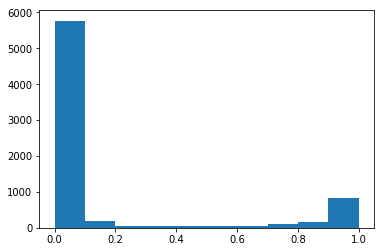

In [14]:
plt.hist(R_pred_frame_label)

In [13]:
torch.save(best_model, 'models/ts_labelmodel_best_tuning.pth')

In [24]:
torch.save(best[2], 'models/ts_labelmodel_best_many_iterations.pth')

In [25]:
best_preds = best[2].predict_element_proba(Li_dev.to(device))

(array([5450.,  253.,   82.,   44.,   41.,   22.,   15.,   33.,   52.,
        1333.]),
 array([1.20012491e-05, 1.00009002e-01, 2.00006003e-01, 3.00003004e-01,
        4.00000005e-01, 4.99997006e-01, 5.99994007e-01, 6.99991008e-01,
        7.99988009e-01, 8.99985010e-01, 9.99982011e-01]),
 <a list of 10 Patch objects>)

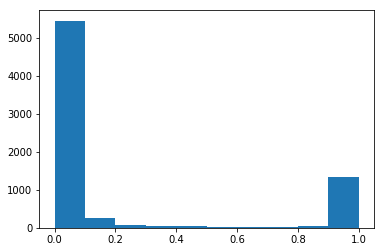

In [31]:
plt.hist(best_preds)

In [8]:
for seed, model in enumerate(temporal_models):
    model.flip_params()
    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame_label = model.predict_element_proba(Li_dev.to(device)) #predict per element

    scores = [iterations, seed, model]
    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), np.round(R_pred_frame_label), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

        scores.append(score)

    if best == None or scores[4] > best[4]:
        best = scores
    print()

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.005
F1: 0.054
Recall: 0.029
Precision: 0.493

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000

Accuracy: 0.176
F1: 0.299
Recall: 1.000
Precision: 0.176

Accuracy: 0.006
F1: 0.068
Recall: 0.036
Precision: 0.522

Accuracy: 0.000
F1: 0.000
Recall: 0.000
Precision: 0.000



In [9]:
print(best)

[2500, 0, DPLabelModel(), 0.17597269624573378, 0.2994192799070848, 1.0, 0.17606884305422757]


In [18]:
torch.save(best, 'models/ts_labelmodel_best_2500.pth')

In [10]:
R_pred_frame_label = best[2].predict_element_proba(Li_dev.to(device))

(array([4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.321e+03]),
 array([0.01257361, 0.11131625, 0.21005889, 0.30880153, 0.40754417,
        0.50628681, 0.60502945, 0.70377209, 0.80251473, 0.90125737,
        1.00000001]),
 <a list of 10 Patch objects>)

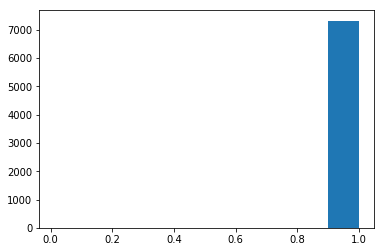

In [13]:
plt.hist(R_pred_frame_label)

In [18]:
preds = markov_model.predict_element_proba(Li_dev.to(device))

In [24]:
preds.shape

(7325,)

In [25]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), np.round(preds), metric)
        print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.154
F1: 0.377
Recall: 0.876
Precision: 0.241


In [26]:
preds[:10]

array([0.99934805, 0.9738352 , 0.97474937, 0.93077044, 0.39215547,
       0.06551916, 0.03445013, 0.03749803, 0.28004386, 0.77988954])

In [28]:
R_pred_probs[:2]

array([[0.516888  , 0.516888  , 0.516888  , 0.516888  , 0.48311198],
       [0.53924423, 0.53924423, 0.53924423, 0.53924423, 0.46075577]],
      dtype=float32)

In [19]:
import matplotlib.pyplot as plt

(array([1638.,  276.,  236.,  135.,  346.,  731.,  854.,  962.,  534.,
        1613.]),
 array([3.50714667e-04, 1.00315638e-01, 2.00280562e-01, 3.00245486e-01,
        4.00210410e-01, 5.00175333e-01, 6.00140257e-01, 7.00105181e-01,
        8.00070105e-01, 9.00035028e-01, 9.99999952e-01]),
 <a list of 10 Patch objects>)

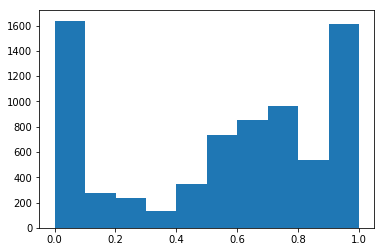

In [20]:
plt.hist(preds)

In [30]:
np.abs(R_pred_frame.detach().cpu().numpy())

array([[3.41327795e-05, 0.00000000e+00, 2.17160606e-03, ...,
        4.27972118e-05, 0.00000000e+00, 3.89957458e-01],
       [2.02080816e-01, 0.00000000e+00, 9.10843536e-03, ...,
        7.04662083e-03, 0.00000000e+00, 5.14468737e-03],
       [6.88242763e-02, 0.00000000e+00, 2.51607329e-01, ...,
        7.77709298e-04, 0.00000000e+00, 4.60530259e-02],
       ...,
       [1.05558075e-02, 0.00000000e+00, 3.71003598e-02, ...,
        7.99736604e-02, 0.00000000e+00, 2.26837486e-01],
       [9.67053056e-05, 0.00000000e+00, 5.52507641e-04, ...,
        4.20493714e-04, 0.00000000e+00, 2.81781822e-01],
       [1.14595937e-03, 0.00000000e+00, 4.02768841e-03, ...,
        7.53226504e-02, 0.00000000e+00, 2.13645339e-01]], dtype=float32)

(array([1523.,  724., 1270.,  681.,  958.,  720.,  430.,  350.,  427.,
         242.]),
 array([0.08463663, 0.17535003, 0.26606343, 0.35677683, 0.44749023,
        0.53820363, 0.62891703, 0.71963043, 0.81034383, 0.90105723,
        0.99177063]),
 <a list of 10 Patch objects>)

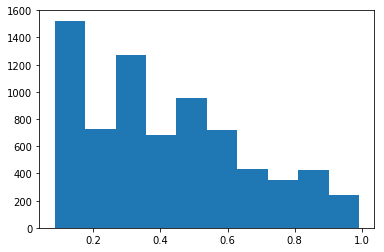

In [23]:
plt.hist(R_pred_probs.ravel())

In [21]:
R_pred_frame

tensor([[0.0000, 0.0000, 0.0022,  ..., 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091,  ..., 0.0070, 0.0000, 0.0051],
        [0.0688, 0.0000, 0.2516,  ..., 0.0008, 0.0000, 0.0461],
        ...,
        [0.0106, 0.0000, 0.0371,  ..., 0.0800, 0.0000, 0.2268],
        [0.0001, 0.0000, 0.0006,  ..., 0.0004, 0.0000, 0.2818],
        [0.0011, 0.0000, 0.0040,  ..., 0.0753, 0.0000, 0.2136]],
       device='cuda:0', grad_fn=<DivBackward1>)

In [22]:
R_pred_frame[0]

tensor([0.0000, 0.0000, 0.0022, 0.0209, 0.0000, 0.0000, 0.0000, 0.0455, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0218, 0.5169, 0.0000, 0.0000,
        0.0001, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0015,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3900],
       device='cuda:0', grad_fn=<SelectBackward>)

In [23]:
R_pred_frame[0].sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [44]:
model.feasible_y

torch.Size([32, 5])

In [45]:
model.feasible_y

tensor([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]], device='cuda:0')

In [46]:
R_pred_frame.shape

torch.Size([1465, 32])

In [63]:
torch.mm(R_pred_frame, torch.where(
    model.feasible_y==-1,torch.tensor(0).to(device),model.feasible_y).float()
).detach().cpu().numpy().ravel()[:10]

array([0.99934804, 0.9738352 , 0.97474945, 0.93077046, 0.39215547,
       0.06551916, 0.03445013, 0.03749803, 0.28004387, 0.7798896 ],
      dtype=float32)

In [65]:
arr = model.feasible_y.detach().cpu().numpy()

In [68]:
arr[arr == -1] = 0

In [69]:
arr

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [71]:
feasible_y_np = model.feasible_y.detach().cpu().numpy()
feasible_y_np[feasible_y_np == -1] = 0
np.matmul(
    R_pred_frame.detach().cpu().numpy(),
    feasible_y_np
).ravel()

array([0.99934805, 0.9738352 , 0.97474937, ..., 0.58535333, 0.58560057,
       0.89727236])

In [57]:
R_pred_frame[:2]

tensor([[0.0000, 0.0000, 0.0022, 0.0209, 0.0000, 0.0000, 0.0000, 0.0455, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0005, 0.0000, 0.0218, 0.5169, 0.0000, 0.0000,
         0.0001, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0015,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091, 0.0045, 0.0000, 0.0020, 0.0000, 0.0003, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0019, 0.0000, 0.0001, 0.0001, 0.4608, 0.0000,
         0.0258, 0.0084, 0.0000, 0.0069, 0.0000, 0.0000, 0.2397, 0.0000, 0.0121,
         0.0000, 0.0140, 0.0070, 0.0000, 0.0051]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [51]:
model.feasible_y

tensor([[-1, -1, -1, -1, -1],
        [-1,  1, -1, -1, -1],
        [ 1, -1, -1, -1, -1],
        [ 1,  1, -1, -1, -1],
        [-1, -1,  1, -1, -1],
        [-1,  1,  1, -1, -1],
        [ 1, -1,  1, -1, -1],
        [ 1,  1,  1, -1, -1],
        [-1, -1, -1,  1, -1],
        [-1,  1, -1,  1, -1],
        [ 1, -1, -1,  1, -1],
        [ 1,  1, -1,  1, -1],
        [-1, -1,  1,  1, -1],
        [-1,  1,  1,  1, -1],
        [ 1, -1,  1,  1, -1],
        [ 1,  1,  1,  1, -1],
        [-1, -1, -1, -1,  1],
        [-1,  1, -1, -1,  1],
        [ 1, -1, -1, -1,  1],
        [ 1,  1, -1, -1,  1],
        [-1, -1,  1, -1,  1],
        [-1,  1,  1, -1,  1],
        [ 1, -1,  1, -1,  1],
        [ 1,  1,  1, -1,  1],
        [-1, -1, -1,  1,  1],
        [-1,  1, -1,  1,  1],
        [ 1, -1, -1,  1,  1],
        [ 1,  1, -1,  1,  1],
        [-1, -1,  1,  1,  1],
        [-1,  1,  1,  1,  1],
        [ 1, -1,  1,  1,  1],
        [ 1,  1,  1,  1,  1]], device='cuda:0')

In [43]:
R_pred_frame

tensor([[0.0000, 0.0000, 0.0022,  ..., 0.0000, 0.0000, 0.3900],
        [0.2021, 0.0000, 0.0091,  ..., 0.0070, 0.0000, 0.0051],
        [0.0688, 0.0000, 0.2516,  ..., 0.0008, 0.0000, 0.0461],
        ...,
        [0.0106, 0.0000, 0.0371,  ..., 0.0800, 0.0000, 0.2268],
        [0.0001, 0.0000, 0.0006,  ..., 0.0004, 0.0000, 0.2818],
        [0.0011, 0.0000, 0.0040,  ..., 0.0753, 0.0000, 0.2136]],
       device='cuda:0', grad_fn=<DivBackward1>)

In [38]:
R_pred_frame.transpose(0, 1)

tensor([[0.0000, 0.2021, 0.0688,  ..., 0.0106, 0.0001, 0.0011],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0022, 0.0091, 0.2516,  ..., 0.0371, 0.0006, 0.0040],
        ...,
        [0.0000, 0.0070, 0.0008,  ..., 0.0800, 0.0004, 0.0753],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3900, 0.0051, 0.0461,  ..., 0.2268, 0.2818, 0.2136]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

In [42]:
torch.mm(model.feasible_y.transpose(dim0=0, dim1=1).float(), R_pred_frame.transpose(0, 1)).transpose(0, 1)

tensor([[ 0.9987,  0.9477,  0.9495,  0.8615, -0.2157],
        [-0.8690, -0.9311, -0.9250, -0.4399,  0.5598],
        [ 0.6989, -0.4822, -0.8752, -0.6246,  0.0817],
        ...,
        [ 0.5028,  0.2961,  0.2270,  0.2729,  0.1078],
        [ 0.9919,  0.9809,  0.2497,  0.0447, -0.1122],
        [ 0.2565,  0.3115,  0.1707,  0.1712,  0.7945]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

In [27]:
torch.dot(model.feasible_y.T, R_pred_frame[0])

RuntimeError: dot: Expected 1-D argument self, but got 2-D

In [16]:
R_pred_frame.shape

torch.Size([1465, 32])

In [19]:
R_pred_frame[0].abs().sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
model.flip_params()

In [9]:
Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

scores = [iterations, seed, model]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.511
F1: 0.304
Recall: 0.605
Precision: 0.203


In [11]:
best_model = best[2]

In [12]:
model = best_model
Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

#find sequence label config. with highest prob.
config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
R_pred_config = model.feasible_y[config_index]
R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

#for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
R_pred_probs = torch.FloatTensor(R_pred_config.shape)
for idx in range(R_pred_config.shape[0]):
    R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

R_pred_probs = R_pred_probs.numpy()
R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
R_pred_frame_label = np.round(R_pred_probs.ravel())
R_pred_frame_label[R_pred_frame_label == 0.] = 2.

scores = [iterations]
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
    print(f"{metric.capitalize()}: {score:.3f}")

    scores.append(score)

Accuracy: 0.939
F1: 0.827
Recall: 0.836
Precision: 0.819


# Save/Load best model

In [24]:
torch.save(model, 'models/ts_labelmodel.pth')

In [3]:
model = torch.load('models/ts_labelmodel.pth').to(device)

In [32]:
model = torch.load('models/ts_labelmodel_best_many_iterations.pth').to(device)

In [34]:
model = torch.load('models/ts_labelmodel_best_tuning.pth').to(device)

In [35]:
model.flip_params()

In [33]:
R_pred_frame_label = model.eval().predict_element_proba(
    MRI_data_temporal['Li_test'].to(device)) #predict per element

for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_test.cpu(), np.round(R_pred_frame_label), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.159
F1: 0.805
Recall: 0.761
Precision: 0.855


# Make predictions for everything and save to disk

In [36]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

## Load manually annotated data

In [37]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 39608.94it/s]


## Load label matrix with all frames in it

In [38]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

## Load videos and number of frames per video

In [39]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

## Construct windows for each video

In [40]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 8)
    ]
    for video_id in video_ids_all
})

## Get ground truth labels for all windows

In [41]:
# Next, intersect the windows with ground truth and get ground truth labels for the windows
windows_intersecting_ground_truth = windows.filter_against(
    clips,
    predicate=overlaps()
).map(lambda intrvl: (intrvl.start, intrvl.end, 2))
windows_with_shot_boundaries = windows_intersecting_ground_truth.filter_against(
    shot_boundaries,
    predicate = lambda window, shot_boundary:
        shot_boundary.start >= window.start and shot_boundary.start < window.end
).map(
    lambda intrvl: (intrvl.start, intrvl.end, 1)
)
windows_with_labels = windows_with_shot_boundaries.set_union(
    windows_intersecting_ground_truth
).coalesce(
    predicate = equal(),
    payload_merge_op = lambda p1, p2: min(p1, p2)
)

## Get weak labels for all windows

In [42]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [ ]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [41]:
with open('../../data/shot_detection_weak_labels/L_everything_windows.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [43]:
with open('../../data/shot_detection_weak_labels/L_everything_windows.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Convert L matrix to timeseries

In [44]:
T = 5
m_per_task = L_everything_windows.shape[1]

In [45]:
L_unlabelled = torch.FloatTensor(L_everything_windows[:L_everything_windows.shape[0] -
                                                      (L_everything_windows.shape[0] % T)]).to(device)

In [46]:
m_per_task_unlabelled = L_unlabelled.size(1)
n_frames_unlabelled = L_unlabelled.size(0)
n_patients_unlabelled = n_frames_unlabelled//T

In [47]:
L_unlabelled_ts = torch.LongTensor(
    L_unlabelled.view(n_patients_unlabelled, (m_per_task*T)).cpu().numpy())

# Predict everything

In [48]:
L_unlabelled_ts.shape[0]

2470104

In [68]:
model.flip_params()

In [91]:
predictions_val = model.eval().predict_element_proba(MRI_data_temporal['Li_dev'])

(array([3068.,   80.,   32.,   30.,   18.,   18.,   28.,   34.,   57.,
         405.]),
 array([8.55662978e-09, 9.99996262e-02, 1.99999244e-01, 2.99998862e-01,
        3.99998479e-01, 4.99998097e-01, 5.99997715e-01, 6.99997332e-01,
        7.99996950e-01, 8.99996568e-01, 9.99996185e-01]),
 <a list of 10 Patch objects>)

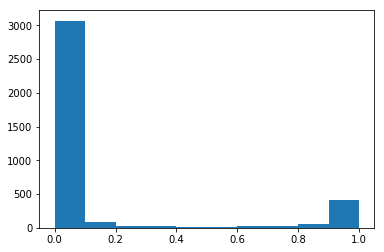

In [92]:
plt.hist(predictions_val)

In [93]:
for metric in ['accuracy', 'f1', 'recall', 'precision']:
    score = metric_score(Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)),
                         np.round(predictions_val), metric)
    print(f"{metric.capitalize()}: {score:.3f}")

Accuracy: 0.951
F1: 0.832
Recall: 0.829
Precision: 0.834


In [94]:
Y_dev.cpu().where(Y_dev.cpu() == torch.tensor(1.), torch.tensor(0.)).numpy()[:100]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [95]:
np.round(predictions_val)[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [72]:
predictions_val[:10]

array([1.40581259e-01, 1.40227477e-01, 1.61227802e-04, 3.84301745e-06,
       5.94221284e-04, 1.06778730e-01, 2.09982789e-02, 2.54221653e-02,
       1.38871080e-02, 1.46137525e-02])

In [73]:
Y_dev[:10]

tensor([1., 1., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:0')

In [98]:
predictions_everything = []
for i in range(0, L_unlabelled_ts.shape[0], 100000):
    print(i)
    start = i
    end = i + 100000
    labels = L_unlabelled_ts[start:end] if end < L_unlabelled_ts.shape[0] else L_unlabelled_ts[start:]
    predictions_for_labels = model.eval().predict_element_proba(labels.to(device))
    predictions_everything.append(predictions_for_labels)
    del predictions_for_labels
    torch.cuda.empty_cache()

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000


In [99]:
np.concatenate(predictions_everything).shape

(12350520,)

In [100]:
R_pred_probs_per_frame = np.concatenate(predictions_everything)

In [14]:
# R_pred_frame = predictions_everything_together

# #find sequence label config. with highest prob.
# config_index = np.argmax(R_pred_frame, axis=1)
# R_pred_config = model.feasible_y[config_index].detach().cpu()
# R_pred_max = torch.FloatTensor(np.max(R_pred_frame.numpy(), axis=1))

# #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
# R_pred_probs = torch.FloatTensor(R_pred_config.shape)
# for idx in range(R_pred_config.shape[0]):
#     R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:]).float()*R_pred_max[idx]

# R_pred_probs = R_pred_probs.numpy()
# R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
# R_pred_frame_label = np.round(R_pred_probs.ravel())
# R_pred_frame_label[R_pred_frame_label == 0.] = 2.

# R_pred_probs_per_frame = R_pred_probs.ravel()

(array([8.3420200e+05, 2.1149000e+04, 7.7870000e+03, 6.8100000e+03,
        8.7200000e+03, 7.8980000e+03, 1.3076000e+04, 1.0069500e+05,
        1.1969400e+05, 1.1230489e+07]),
 array([1.08796358e-09, 9.99999900e-02, 1.99999979e-01, 2.99999968e-01,
        3.99999957e-01, 4.99999946e-01, 5.99999935e-01, 6.99999924e-01,
        7.99999913e-01, 8.99999902e-01, 9.99999891e-01]),
 <a list of 10 Patch objects>)

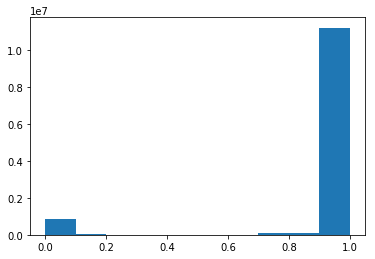

In [101]:
plt.hist(R_pred_probs_per_frame)

In [106]:
L_unlabelled_ts[-10:]

tensor([[2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0,
         0],
        [2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0,
         0],
        [1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0,
         0]])

In [129]:
L_everything_windows[1000000:1000100]

array([[2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2, 2, 1],
       [2, 2, 2,

In [130]:
L_unlabelled[1000000:1000100]

tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 0., 0.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 1.],
        [2., 2., 2., 2., 1.],
        [2

In [131]:
for i in range(100):
    print(R_pred_probs_per_frame[i + 1000000])

0.005078098890923699
0.0003913204089874833
0.0014480455645232704
0.0014508530056153157
0.01354255598348486
0.03253716003112722
0.0007590468415920593
0.0007431183237380234
0.00028649486911341837
0.002593912226161954
0.0018647281320323117
0.9991726876057854
0.999791628469211
0.000762786984841668
0.019824447749028806
0.0027112675165555378
0.00030145259904595934
0.00038404626502536177
0.00037671071476036433
0.004816053324366465
3.9306247322476104e-05
4.1861330792505175e-06
2.826889425862865e-05
0.0002153524397428743
0.004812799428182904
0.005065578929722744
0.00039091473906242846
0.0003835648675527964
0.00022959204119903098
0.001110630339805671
3.9262731529425974e-05
3.718266664914184e-07
2.6777967627359225e-07
3.945536968773676e-06
0.0006109908980965464
3.9262731529425974e-05
3.718266664914184e-07
2.6777967627359225e-07
3.945536968773676e-06
0.0006109908980965464
3.9300865168037885e-05
3.720164123257653e-07
3.834042406382582e-06
2.8692889826422102e-05
0.004647517259257665
0.00487484708618

(array([8.3420200e+05, 2.1149000e+04, 7.7870000e+03, 6.8100000e+03,
        8.7200000e+03, 7.8980000e+03, 1.3076000e+04, 1.0069500e+05,
        1.1969400e+05, 1.1230489e+07]),
 array([1.08796358e-09, 9.99999900e-02, 1.99999979e-01, 2.99999968e-01,
        3.99999957e-01, 4.99999946e-01, 5.99999935e-01, 6.99999924e-01,
        7.99999913e-01, 8.99999902e-01, 9.99999891e-01]),
 <a list of 10 Patch objects>)

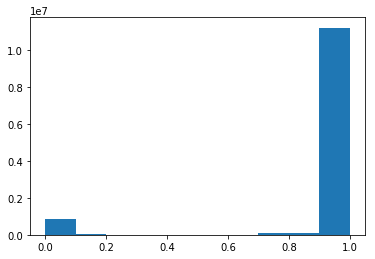

In [59]:
plt.hist(R_pred_probs_per_frame)

In [63]:
R_pred_probs_per_frame[-10:]

array([0.98128119, 0.98241826, 0.99931511, 0.9960668 , 0.74069486,
       0.80678443, 0.99510206, 0.98100089, 0.91893201, 0.97323139])

# Save predictions to disk

In [39]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [40]:
predictions_to_save_windows = [
    (window_info, np.array([prediction, 1. - prediction]))
    for window_info, prediction in zip(window_nums, R_pred_probs_per_frame)
]

In [41]:
# Because we needed to cut the predictions to a multiple of T
last_preds = []
for window_info in window_nums[len(predictions_to_save_windows):]:
    last_preds.append((window_info, np.array([0., 1.])))

In [42]:
predictions_to_save_windows += last_preds

In [43]:
preds_np_windows = np.array(predictions_to_save_windows)

In [44]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/ts_weak_labels_all_windows_tuned.npy', 'wb') as f:
    np.save(f, preds_np_windows)

# Distribution compared to Metal LabelModel

In [66]:
import matplotlib.pyplot as plt

In [59]:
preds_np_windows[:10]

array([[(1, 0, 16), array([0., 1.])],
       [(1, 8, 24), array([0., 1.])],
       [(1, 16, 32), array([0., 1.])],
       [(1, 24, 40), array([0., 1.])],
       [(1, 32, 48), array([0., 1.])],
       [(1, 40, 56), array([0.01515144, 0.98484856])],
       [(1, 48, 64), array([0.98484856, 0.01515144])],
       [(1, 56, 72), array([0.98484856, 0.01515144])],
       [(1, 64, 80), array([0.01515144, 0.98484856])],
       [(1, 72, 88), array([0.01515144, 0.98484856])]], dtype=object)

In [64]:
preds_np_windows.shape

(12350523, 2)

In [62]:
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_metal = np.load(f)

In [63]:
preds_np_windows_metal[:10]

array([[(1, 0, 16), array([0.0032828, 0.9967172])],
       [(1, 8, 24), array([0.0032828, 0.9967172])],
       [(1, 16, 32), array([0.0032828, 0.9967172])],
       [(1, 24, 40), array([0.0032828, 0.9967172])],
       [(1, 32, 48), array([0.0032828, 0.9967172])],
       [(1, 40, 56), array([0.24933879, 0.75066121])],
       [(1, 48, 64), array([0.98051349, 0.01948651])],
       [(1, 56, 72), array([0.36412127, 0.63587873])],
       [(1, 64, 80), array([0.0032828, 0.9967172])],
       [(1, 72, 88), array([0.0032828, 0.9967172])]], dtype=object)

In [65]:
preds_np_windows_metal.shape

(12350523, 2)

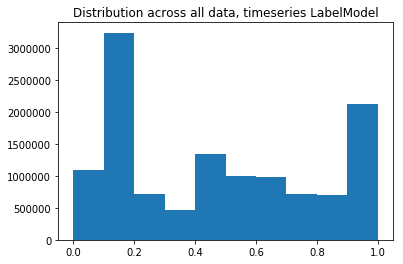

In [75]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, timeseries LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows
])
plt.show()

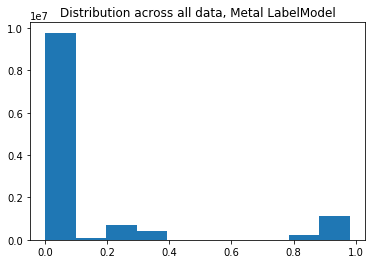

In [76]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Metal LabelModel')
ax.hist([
    i[1][0]
    for i in preds_np_windows_metal
])
plt.show()

In [79]:
with open('../../data/shot_detection_weak_labels/majority_vote_labels_all_windows.npy', 'rb') as f:
    preds_np_windows_mv = np.load(f)

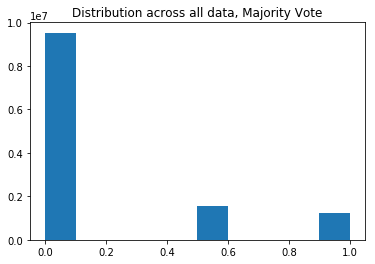

In [81]:
fig, ax = plt.subplots()
ax.set_title('Distribution across all data, Majority Vote')
ax.hist([
    i[1][0]
    for i in preds_np_windows_mv
])
plt.show()

# Old stuff (bad class balance, wrong R_dev)

In [97]:
%%time 
max_seed = 10
temporal_models = [None,]*max_seed
for seed in range(max_seed):
    markov_model = DPLabelModel(m=m_per_task*T, 
                                T=T,
                                edges=[(i,i+m_per_task) for i in range((T-1)*m_per_task)],
                                coverage_sets=[[t,] for t in range(T) for _ in range(m_per_task)],
                                mu_sharing=[[t*m_per_task+i for t in range(T)] for i in range(m_per_task)],
                                phi_sharing=[[(t*m_per_task+i, (t+1)*m_per_task+i) for t in range(T-1)] for i in range(m_per_task)],
                                device=device,
                                # class_balance=MRI_data_temporal['class_balance'],
                                seed=seed)
    optimize(markov_model, L_hat=MRI_data_temporal['Li_train'], num_iter=10, lr=1e-5, momentum=0.8, clamp=True, 
             verbose=False, seed=seed)
    temporal_models[seed] = markov_model

CPU times: user 41.8 s, sys: 1.6 s, total: 43.4 s
Wall time: 43.4 s


In [98]:
for seed, model in enumerate(temporal_models):
    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]

    Li_dev = torch.LongTensor(MRI_data_temporal['Li_dev'].cpu().numpy())
    R_pred_frame = model.predict_proba(Li_dev.to(device)) #predict per sequence

    #find sequence label config. with highest prob.
    config_index = np.argmax(R_pred_frame.detach().cpu().numpy(), axis=1) 
    R_pred_config = model.feasible_y[config_index]
    R_pred_max = torch.FloatTensor(np.max(R_pred_frame.detach().cpu().numpy(), axis=1))

    #for each 1 in config, multiply by prob. label for sequence (1-prob label otherwise)
    R_pred_probs = torch.FloatTensor(R_pred_config.shape)
    for idx in range(R_pred_config.shape[0]):
        R_pred_probs[idx,:] = torch.LongTensor(R_pred_config[idx,:].cpu()).float()*R_pred_max[idx]

    R_pred_probs = R_pred_probs.numpy()
    R_pred_probs[R_pred_probs < 0] = 1+R_pred_probs[R_pred_probs < 0]
    R_pred_frame_label = np.round(R_pred_probs.ravel())
    R_pred_frame_label[R_pred_frame_label == 0.] = 2.

    for metric in ['accuracy', 'f1', 'recall', 'precision']:
        score = metric_score(Y_dev.cpu(), R_pred_frame_label, metric)
        print(f"{metric.capitalize()}: {score:.3f}")

(7325,)
Accuracy: 0.357
F1: 0.090
Recall: 0.182
Precision: 0.060
(7325,)
Accuracy: 0.369
F1: 0.184
Recall: 0.404
Precision: 0.119
(7325,)
Accuracy: 0.523
F1: 0.218
Recall: 0.377
Precision: 0.153
(7325,)
Accuracy: 0.388
F1: 0.225
Recall: 0.506
Precision: 0.145
(7325,)
Accuracy: 0.375
F1: 0.234
Recall: 0.542
Precision: 0.149
(7325,)
Accuracy: 0.668
F1: 0.344
Recall: 0.494
Precision: 0.263
(7325,)
Accuracy: 0.580
F1: 0.086
Recall: 0.112
Precision: 0.069
(7325,)
Accuracy: 0.509
F1: 0.154
Recall: 0.254
Precision: 0.111
(7325,)
Accuracy: 0.277
F1: 0.024
Recall: 0.050
Precision: 0.015
(7325,)
Accuracy: 0.544
F1: 0.279
Recall: 0.500
Precision: 0.193


In [18]:
# num_iter=1 (20s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904 


In [20]:
# num_iter=10 (40s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [22]:
# num_iter=50 (2 min 25s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [24]:
# num_iter=100 (4 min 28s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 


In [26]:
# num_iter=500 (22 min 2s wall time)
for seed, model in enumerate(temporal_models):
    R_pred = model.predict(MRI_data_temporal['Li_dev'])
    F1 = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'f1')
    accuracy = metric_score(MRI_data_temporal['R_dev'].cpu(), R_pred.cpu(), 'accuracy')
    pre = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'precision')
    rec = metric_score(MRI_data_temporal['R_dev'].cpu()>0, R_pred.cpu()>0, 'recall')
    print(f"seed={seed}  accuracy={accuracy:.3f}  F1={F1:.3f}  precision={pre:.3f} recall={rec:.3f} ")

seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 


# Notes on runs

```
1 iteration:
seed=0  accuracy=0.207  F1=0.294  precision=0.175 recall=0.931 
seed=1  accuracy=0.208  F1=0.270  precision=0.161 recall=0.823 
seed=2  accuracy=0.730  F1=0.168  precision=0.185 recall=0.154 
seed=3  accuracy=0.182  F1=0.300  precision=0.177 recall=0.988 
seed=4  accuracy=0.196  F1=0.283  precision=0.168 recall=0.892 
seed=5  accuracy=0.674  F1=0.143  precision=0.134 recall=0.154 
seed=6  accuracy=0.812  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.499  F1=0.193  precision=0.135 recall=0.338 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.639  F1=0.470  precision=0.318 recall=0.904

10 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.616  F1=0.228  precision=0.177 recall=0.319 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.174  F1=0.293  precision=0.173 recall=0.965 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.739  F1=0.073  precision=0.098 recall=0.058 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000

50 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=4  accuracy=0.661  F1=0.347  precision=0.263 recall=0.508 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.386  F1=0.334  precision=0.207 recall=0.865 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

100 iterations:
seed=0  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=1  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=2  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=3  accuracy=0.621  F1=0.224  precision=0.176 recall=0.308 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=6  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=7  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=8  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 
seed=9  accuracy=0.177  F1=0.301  precision=0.177 recall=1.000 

500 iterations:
seed=0  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=1  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=2  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=3  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=4  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=5  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=6  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=7  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=8  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
seed=9  accuracy=0.823  F1=0.000  precision=0.000 recall=0.000 
```